In [2]:
## Load modules

# Standard modules
import pandas as pd
import numpy as np
import os
import sklearn

# Statistics module
import scipy.stats as ss

# Regular expression module
import re

# Thanks to Srikant Sir from AIML for the following:
# sklearn 0.22.1 onwards uses sklearn.neighbors._base instead of sklearn.neighbors.base
# re register with alias in such cases
import sys
if sklearn.__version__ >= '0.22.1':
    import sklearn.neighbors._base
    sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

# Preprocessing modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,\
 OneHotEncoder, LabelEncoder, OrdinalEncoder

# Train-test split module
from sklearn.model_selection import train_test_split

# Model selection modules
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

# Pipeline module
from sklearn.pipeline import Pipeline

# Imputation modules
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from missingpy import MissForest
import missingno as msno

# Classifier modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# Regression modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor

# Clustering modules
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# Performance metric modules
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots

pd.options.display.max_columns = None

# Module for categorical variables
from pandas.api.types import CategoricalDtype

# Modules for building custom encoders and transformers
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
## Load Sepsis Data
file = 'SepsisDataSet.csv'
sepsisDf = pd.read_csv(file, sep = ',', header = 0)

print('Sepsis dataset')
print('-----------')
print('Initial number of samples = %d'%(sepsisDf.shape[0]))
print('Initial number of features = %d\n'%(sepsisDf.shape[1]))
sepsisDf.head(5)

Sepsis dataset
-----------
Initial number of samples = 449
Initial number of features = 64



,Age,Sex,Speciality,DOAHOSP,IDOAICU,DOICU,DODHOSP,VAR00001,Clinical_Diagnosis,expired_within_48hr,Pnemonia,UTI,Acute_abdominal_infection,meningitis,soft_tissue_infection,bone_joint_infection,wound_infection,CABSI,Endocarditis,implantable_device_infection,Gynaecological_infection,Deep_organ_abscess,others,Hyperthermia,Hypothermia,altered_mental_status,Tachycardia,Tachypnea,Leukocytosis,Leukopenia,Hyperglycemia,SBP,URINE_OUTPUT,SaO2,FiO2,pH,PaO2,TLC,DLC,Bands,Hb,ESR,Platelet_count,AST,ALK_phosphatase,Total_Blirubin,Urea,Creatinine,RBS,Gly_Hb,CRP,GCS,Blood_culture_positive,immunocompromised,HIV,HBsAg,Diabetes,steroid,previous_hospitaliation,Hypertention,Asthma,COPD,Renal_disease,PROGNOSIS
0,76.0,F,MED,28.11.16,28.11.16,30.11.16,03.12.16,ED,,NaN,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,150.0,100.0,91.0,0.6,7.41,60.0,30000.0,"N-77%, left shift+,L-8%,M-4%, Band-24%",24.0,9.4,26.0,392000.0,26.0,175.0,0.5,16.1,1.1,162.0,5.5,NaN,6.0,Yes,no,No,No,Yes,No,No,yes,No,No,No,Recovered
1,35.0,M,SUR,25.11.16,01.12.16,08.12.16,14.12.16,other ICU,Perforation peritonitis,no,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,Yes,130.0,30.0,99.0,0.4,7.12,232.0,14600.0,"N-70%, left shift+, L-4%, M-2%, Band-60%",60.0,17.2,4.0,263000.0,55.0,84.0,0.5,73.0,1.2,195.0,5.9,NaN,8.0,No,no,No,No,No,No,No,No,No,No,No,died
2,58.0,F,MED,01.12.16,01.12.16,06.12.16,06.12.16,ED,"Mengigo-encephalitis, AkI,T2DM",NaN,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,Yes,Yes,No,Yes,140.0,200.0,97.0,0.4,7.38,101.0,39900.0,"N-76%, left shift, L-6%, M-5%, Band-12%",12.0,11.1,69.0,146000.0,50.0,134.0,1.0,160.0,3.4,158.0,5.0,431.0,8.0,Yes,no,No,No,Yes,No,No,No,No,No,yes,Recovered
3,42.0,M,MED,03.12.16,03.12.16,25.01.17,25.01.17,ED,"Pyomyositis,sepsis with septic shock, MODS, AKI",NaN,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,No,80.0,100.0,98.0,0.4,7.32,165.0,16700.0,"N-57%, left shift+, L-10%, M-8%, Band-19%",19.0,18.4,4.0,135000.0,147.0,28.0,1.5,33.0,1.8,131.0,5.9,130.8,8.0,Yes,no,No,No,No,No,No,No,No,No,No,Recovered
4,52.0,M,MED,03.12.16,03.12.16,12.12.16,12.12.16,ED,Rt sided pneumonia with sepsis,no,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,No,Yes,110.0,50.0,85.0,0.6,7.34,53.0,1800.0,"N-25%, left shift, L-14%, M-3%, Bands-46%",46.0,9.8,4.0,50000.0,658.0,199.0,2.5,41.0,1.1,411.0,6.1,86.0,8.0,No,no,No,No,Yes,No,No,yes,No,No,No,died


In [4]:
sepsisDf.dropna(how = 'all', inplace = True)

print('Sepsis dataset after dropping records having all NaN values')
print('-----------')
print('Number of samples = %d'%(sepsisDf.shape[0]))
print('Number of features = %d\n'%(sepsisDf.shape[1]))
sepsisDf.head(5)

Sepsis dataset after dropping records having all NaN values
-----------
Number of samples = 400
Number of features = 64



,Age,Sex,Speciality,DOAHOSP,IDOAICU,DOICU,DODHOSP,VAR00001,Clinical_Diagnosis,expired_within_48hr,Pnemonia,UTI,Acute_abdominal_infection,meningitis,soft_tissue_infection,bone_joint_infection,wound_infection,CABSI,Endocarditis,implantable_device_infection,Gynaecological_infection,Deep_organ_abscess,others,Hyperthermia,Hypothermia,altered_mental_status,Tachycardia,Tachypnea,Leukocytosis,Leukopenia,Hyperglycemia,SBP,URINE_OUTPUT,SaO2,FiO2,pH,PaO2,TLC,DLC,Bands,Hb,ESR,Platelet_count,AST,ALK_phosphatase,Total_Blirubin,Urea,Creatinine,RBS,Gly_Hb,CRP,GCS,Blood_culture_positive,immunocompromised,HIV,HBsAg,Diabetes,steroid,previous_hospitaliation,Hypertention,Asthma,COPD,Renal_disease,PROGNOSIS
0,76.0,F,MED,28.11.16,28.11.16,30.11.16,03.12.16,ED,,NaN,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,150.0,100.0,91.0,0.6,7.41,60.0,30000.0,"N-77%, left shift+,L-8%,M-4%, Band-24%",24.0,9.4,26.0,392000.0,26.0,175.0,0.5,16.1,1.1,162.0,5.5,NaN,6.0,Yes,no,No,No,Yes,No,No,yes,No,No,No,Recovered
1,35.0,M,SUR,25.11.16,01.12.16,08.12.16,14.12.16,other ICU,Perforation peritonitis,no,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,Yes,130.0,30.0,99.0,0.4,7.12,232.0,14600.0,"N-70%, left shift+, L-4%, M-2%, Band-60%",60.0,17.2,4.0,263000.0,55.0,84.0,0.5,73.0,1.2,195.0,5.9,NaN,8.0,No,no,No,No,No,No,No,No,No,No,No,died
2,58.0,F,MED,01.12.16,01.12.16,06.12.16,06.12.16,ED,"Mengigo-encephalitis, AkI,T2DM",NaN,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,Yes,Yes,No,Yes,140.0,200.0,97.0,0.4,7.38,101.0,39900.0,"N-76%, left shift, L-6%, M-5%, Band-12%",12.0,11.1,69.0,146000.0,50.0,134.0,1.0,160.0,3.4,158.0,5.0,431.0,8.0,Yes,no,No,No,Yes,No,No,No,No,No,yes,Recovered
3,42.0,M,MED,03.12.16,03.12.16,25.01.17,25.01.17,ED,"Pyomyositis,sepsis with septic shock, MODS, AKI",NaN,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,No,80.0,100.0,98.0,0.4,7.32,165.0,16700.0,"N-57%, left shift+, L-10%, M-8%, Band-19%",19.0,18.4,4.0,135000.0,147.0,28.0,1.5,33.0,1.8,131.0,5.9,130.8,8.0,Yes,no,No,No,No,No,No,No,No,No,No,Recovered
4,52.0,M,MED,03.12.16,03.12.16,12.12.16,12.12.16,ED,Rt sided pneumonia with sepsis,no,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,No,Yes,110.0,50.0,85.0,0.6,7.34,53.0,1800.0,"N-25%, left shift, L-14%, M-3%, Bands-46%",46.0,9.8,4.0,50000.0,658.0,199.0,2.5,41.0,1.1,411.0,6.1,86.0,8.0,No,no,No,No,Yes,No,No,yes,No,No,No,died


In [7]:
#encoding the values of gender column 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit_transform(sepsisDf.loc[:,'Sex'])

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,

<AxesSubplot:>

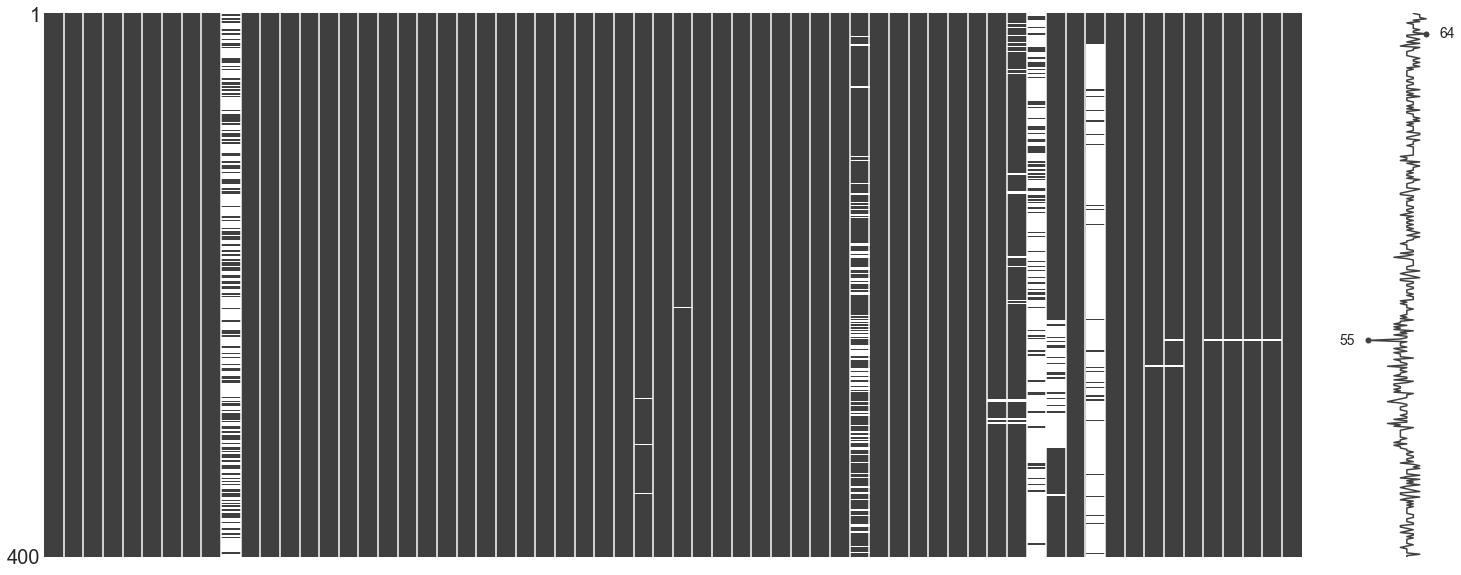

In [8]:
# Plot missingness matrix of the Sepsis dataset
msno.matrix(sepsisDf)

In [10]:
#Conversion of columns with yes or no values to 0 and 1
columns = ['Pnemonia',	'UTI',	'Acute_abdominal_infection',	'meningitis',	'soft_tissue_infection',	'bone_joint_infection',	'wound_infection',	'CABSI',	'Endocarditis',	'implantable_device_infection',	'Gynaecological_infection',	'Deep_organ_abscess',	'others',	'Hyperthermia',	'Hypothermia',	'altered_mental_status',	'Tachycardia',	'Tachypnea',	'Leukocytosis',	'Leukopenia',	'Hyperglycemia', 'Blood_culture_positive',	'HIV',	'HBsAg',	'Diabetes',	'steroid',	'previous_hospitaliation',	'Hypertention',	'Asthma',	'COPD',	'Renal_disease']
for column in columns:
  for i in range(len(sepsisDf[column])):
    if 'yes' in str(sepsisDf[column][i]).strip().lower():
      sepsisDf[column][i] = 1
    if 'no' in str(sepsisDf[column][i]).strip().lower():
      sepsisDf[column][i] = 0

<ipython-input-10-dc72a978008a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsisDf[column][i] = 0
<ipython-input-10-dc72a978008a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsisDf[column][i] = 1


In [11]:
sepsisDf

,Age,Sex,Speciality,DOAHOSP,IDOAICU,DOICU,DODHOSP,VAR00001,Clinical_Diagnosis,expired_within_48hr,Pnemonia,UTI,Acute_abdominal_infection,meningitis,soft_tissue_infection,bone_joint_infection,wound_infection,CABSI,Endocarditis,implantable_device_infection,Gynaecological_infection,Deep_organ_abscess,others,Hyperthermia,Hypothermia,altered_mental_status,Tachycardia,Tachypnea,Leukocytosis,Leukopenia,Hyperglycemia,SBP,URINE_OUTPUT,SaO2,FiO2,pH,PaO2,TLC,DLC,Bands,Hb,ESR,Platelet_count,AST,ALK_phosphatase,Total_Blirubin,Urea,Creatinine,RBS,Gly_Hb,CRP,GCS,Blood_culture_positive,immunocompromised,HIV,HBsAg,Diabetes,steroid,previous_hospitaliation,Hypertention,Asthma,COPD,Renal_disease,PROGNOSIS
0,76.0,F,MED,28.11.16,28.11.16,30.11.16,03.12.16,ED,,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,150.0,100.0,91.0,0.6,7.41,60.0,30000.0,"N-77%, left shift+,L-8%,M-4%, Band-24%",24.0,9.4,26.0,392000.0,26.0,175.0,0.5,16.1,1.1,162.0,5.5,NaN,6.0,1,no,0,0,1,0,0,1,0,0,0,Recovered
1,35.0,M,SUR,25.11.16,01.12.16,08.12.16,14.12.16,other ICU,Perforation peritonitis,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,130.0,30.0,99.0,0.4,7.12,232.0,14600.0,"N-70%, left shift+, L-4%, M-2%, Band-60%",60.0,17.2,4.0,263000.0,55.0,84.0,0.5,73.0,1.2,195.0,5.9,NaN,8.0,0,no,0,0,0,0,0,0,0,0,0,died
2,58.0,F,MED,01.12.16,01.12.16,06.12.16,06.12.16,ED,"Mengigo-encephalitis, AkI,T2DM",NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,140.0,200.0,97.0,0.4,7.38,101.0,39900.0,"N-76%, left shift, L-6%, M-5%, Band-12%",12.0,11.1,69.0,146000.0,50.0,134.0,1.0,160.0,3.4,158.0,5.0,431.0,8.0,1,no,0,0,1,0,0,0,0,0,1,Recovered
3,42.0,M,MED,03.12.16,03.12.16,25.01.17,25.01.17,ED,"Pyomyositis,sepsis with septic shock, MODS, AKI",NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,80.0,100.0,98.0,0.4,7.32,165.0,16700.0,"N-57%, left shift+, L-10%, M-8%, Band-19%",19.0,18.4,4.0,135000.0,147.0,28.0,1.5,33.0,1.8,131.0,5.9,130.8,8.0,1,no,0,0,0,0,0,0,0,0,0,Recovered
4,52.0,M,MED,03.12.16,03.12.16,12.12.16,12.12.16,ED,Rt sided pneumonia with sepsis,no,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,110.0,50.0,85.0,0.6,7.34,53.0,1800.0,"N-25%, left shift, L-14%, M-3%, Bands-46%",46.0,9.8,4.0,50000.0,658.0,199.0,2.5,41.0,1.1,411.0,6.1,86.0,8.0,0,no,0,0,1,0,0,1,0,0,0,died
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,33.0,M,Trauma,18.05.18,18.05.18,30.05.18,30.05.18,ED,"right SAH, post RTA,closed head injury,C7 lami...",NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,150.0,200.0,97.0,0.5,7.08,99.0,10100.0,"N-96.4%,Left shift+, L-2.3%",0.0,12.3,85.0,319000.0,60.0,49.0,1.6,18.0,0.5,109.0,5.0,NaN,7.0,1,NaN,0,0,0,0,1,1,0,0,0,lost to followup
396,28.0,M,MED,14.05.18,14.05.18,19.05.18,29.05.18,ED,"febrile illness with thrombocytopenia,SAH,infe...",no,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,1,0,0,160.0,130.0,97.0,0.4,7.17,96.0,31400.0,"N-86.4%,Left shift+, L-6.8%",0.0,12.1,NaN,21000.0,34.0,132.0,0.9,45.0,1.0,113.0,5.8,NaN,11.0,1,NaN,0,0,0,0,0,1,0,0,0,Recovered
397,48.0,F,MED,05.05.18,05.05.18,07.05.18,07.05.18,ED,"RVD,PCP pneumonia,sepsis with septic shock,sev...",yes,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,80.0,120.0,97.0,0.5,7.44,102.0,23800.0,"N-75%,Left shift+, L-2%, Bands-18%",18.0,9.8,17.0,90000.0,19.0,66.0,0.5,49.0,1.3,100.0,5.2,NaN,9.0,1,yes,1,0,0,1,0,0,0,0,0,died
398,42.0,M,SUR,17.04.18,17.04.18,29.04.18,18.05.18,ED,"perforation peritonitis,duodenal leak,SSI",NaN,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,90.0,100.0,95.0,0.6,7.17,85.0,1600.0,"N-17%,Left shift+, L-20%, Bands-40%",40.0,18.6,10.0,229000.0,91.0,45.0,1.4,73.0,1.7,106.0,4.8,NaN,11.0,0,NaN,0,0,0,0,0,0,0,0,0,Recovered


Text(0, 0.5, '% Missing Values')

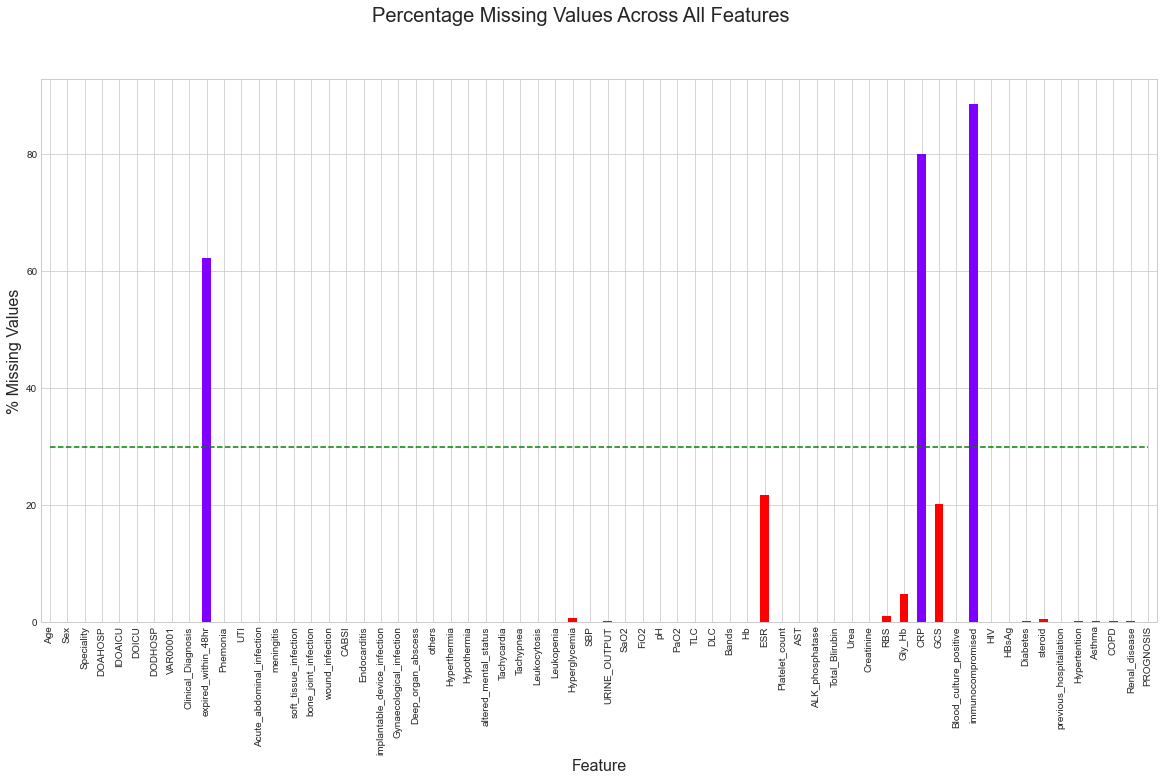

In [12]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30 # we will remove features missing in more than 30% of the samples
fig = plt.figure(figsize=(20,10))
percent_missing = (sepsisDf.isna().sum() / sepsisDf.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(sepsisDf.shape[1]), np.repeat(cutoff, sepsisDf.shape[1]), 'g--') 
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 20)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('% Missing Values', fontsize = 16)

In [13]:
#Percentage of missing values across all features
missingDf = pd.DataFrame((sepsisDf.isna().sum() / sepsisDf.shape[0])*100)
missingDf[sepsisDf.isna().sum() > 0]

,0
expired_within_48hr,62.25
Hyperglycemia,0.75
URINE_OUTPUT,0.25
ESR,21.75
RBS,1.00
Gly_Hb,4.75
CRP,80.00
GCS,20.25
immunocompromised,88.50
Diabetes,0.25


In [15]:
sepsisDf.drop(columns=['CRP', 'immunocompromised','expired_within_48hr'], inplace = True)

In [16]:
sepsisDf

,Age,Sex,Speciality,DOAHOSP,IDOAICU,DOICU,DODHOSP,VAR00001,Clinical_Diagnosis,Pnemonia,UTI,Acute_abdominal_infection,meningitis,soft_tissue_infection,bone_joint_infection,wound_infection,CABSI,Endocarditis,implantable_device_infection,Gynaecological_infection,Deep_organ_abscess,others,Hyperthermia,Hypothermia,altered_mental_status,Tachycardia,Tachypnea,Leukocytosis,Leukopenia,Hyperglycemia,SBP,URINE_OUTPUT,SaO2,FiO2,pH,PaO2,TLC,DLC,Bands,Hb,ESR,Platelet_count,AST,ALK_phosphatase,Total_Blirubin,Urea,Creatinine,RBS,Gly_Hb,GCS,Blood_culture_positive,HIV,HBsAg,Diabetes,steroid,previous_hospitaliation,Hypertention,Asthma,COPD,Renal_disease,PROGNOSIS
0,76.0,F,MED,28.11.16,28.11.16,30.11.16,03.12.16,ED,,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,150.0,100.0,91.0,0.6,7.41,60.0,30000.0,"N-77%, left shift+,L-8%,M-4%, Band-24%",24.0,9.4,26.0,392000.0,26.0,175.0,0.5,16.1,1.1,162.0,5.5,6.0,1,0,0,1,0,0,1,0,0,0,Recovered
1,35.0,M,SUR,25.11.16,01.12.16,08.12.16,14.12.16,other ICU,Perforation peritonitis,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,130.0,30.0,99.0,0.4,7.12,232.0,14600.0,"N-70%, left shift+, L-4%, M-2%, Band-60%",60.0,17.2,4.0,263000.0,55.0,84.0,0.5,73.0,1.2,195.0,5.9,8.0,0,0,0,0,0,0,0,0,0,0,died
2,58.0,F,MED,01.12.16,01.12.16,06.12.16,06.12.16,ED,"Mengigo-encephalitis, AkI,T2DM",0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,140.0,200.0,97.0,0.4,7.38,101.0,39900.0,"N-76%, left shift, L-6%, M-5%, Band-12%",12.0,11.1,69.0,146000.0,50.0,134.0,1.0,160.0,3.4,158.0,5.0,8.0,1,0,0,1,0,0,0,0,0,1,Recovered
3,42.0,M,MED,03.12.16,03.12.16,25.01.17,25.01.17,ED,"Pyomyositis,sepsis with septic shock, MODS, AKI",0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,80.0,100.0,98.0,0.4,7.32,165.0,16700.0,"N-57%, left shift+, L-10%, M-8%, Band-19%",19.0,18.4,4.0,135000.0,147.0,28.0,1.5,33.0,1.8,131.0,5.9,8.0,1,0,0,0,0,0,0,0,0,0,Recovered
4,52.0,M,MED,03.12.16,03.12.16,12.12.16,12.12.16,ED,Rt sided pneumonia with sepsis,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,110.0,50.0,85.0,0.6,7.34,53.0,1800.0,"N-25%, left shift, L-14%, M-3%, Bands-46%",46.0,9.8,4.0,50000.0,658.0,199.0,2.5,41.0,1.1,411.0,6.1,8.0,0,0,0,1,0,0,1,0,0,0,died
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,33.0,M,Trauma,18.05.18,18.05.18,30.05.18,30.05.18,ED,"right SAH, post RTA,closed head injury,C7 lami...",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,150.0,200.0,97.0,0.5,7.08,99.0,10100.0,"N-96.4%,Left shift+, L-2.3%",0.0,12.3,85.0,319000.0,60.0,49.0,1.6,18.0,0.5,109.0,5.0,7.0,1,0,0,0,0,1,1,0,0,0,lost to followup
396,28.0,M,MED,14.05.18,14.05.18,19.05.18,29.05.18,ED,"febrile illness with thrombocytopenia,SAH,infe...",0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,1,0,0,160.0,130.0,97.0,0.4,7.17,96.0,31400.0,"N-86.4%,Left shift+, L-6.8%",0.0,12.1,NaN,21000.0,34.0,132.0,0.9,45.0,1.0,113.0,5.8,11.0,1,0,0,0,0,0,1,0,0,0,Recovered
397,48.0,F,MED,05.05.18,05.05.18,07.05.18,07.05.18,ED,"RVD,PCP pneumonia,sepsis with septic shock,sev...",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,80.0,120.0,97.0,0.5,7.44,102.0,23800.0,"N-75%,Left shift+, L-2%, Bands-18%",18.0,9.8,17.0,90000.0,19.0,66.0,0.5,49.0,1.3,100.0,5.2,9.0,1,1,0,0,1,0,0,0,0,0,died
398,42.0,M,SUR,17.04.18,17.04.18,29.04.18,18.05.18,ED,"perforation peritonitis,duodenal leak,SSI",0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,90.0,100.0,95.0,0.6,7.17,85.0,1600.0,"N-17%,Left shift+, L-20%, Bands-40%",40.0,18.6,10.0,229000.0,91.0,45.0,1.4,73.0,1.7,106.0,4.8,11.0,0,0,0,0,0,0,0,0,0,0,Recovered


In [17]:
#Percentage of missing values across all features
missingDf = pd.DataFrame((sepsisDf.isna().sum() / sepsisDf.shape[0])*100)
missingDf[sepsisDf.isna().sum() > 0]

,0
Hyperglycemia,0.75
URINE_OUTPUT,0.25
ESR,21.75
RBS,1.00
Gly_Hb,4.75
GCS,20.25
Diabetes,0.25
steroid,0.50
Hypertention,0.25
Asthma,0.25


In [18]:
new_df = sepsisDf[['Age','RBS','Gly_Hb','ESR']]

inds1 = list(set(np.random.randint(0, 10, 10)))

print(inds1)

# Replace the values at given index position with NaNs
new_df['RBS'] = [val if i not in inds1 else np.nan for i, val in enumerate(new_df['RBS'])]
new_df['Gly_Hb'] = [val if i not in inds1 else np.nan for i, val in enumerate(new_df['Gly_Hb'])]
new_df['ESR'] = [val if i not in inds1 else np.nan for i, val in enumerate(new_df['ESR'])]

# Get count of missing values by column
print(new_df.isnull().sum())

new_df

[0, 1, 3, 4, 7, 9]
Age        0
RBS       10
Gly_Hb    24
ESR       93
dtype: int64


<ipython-input-18-1d23bd6820f6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['RBS'] = [val if i not in inds1 else np.nan for i, val in enumerate(new_df['RBS'])]
<ipython-input-18-1d23bd6820f6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Gly_Hb'] = [val if i not in inds1 else np.nan for i, val in enumerate(new_df['Gly_Hb'])]
<ipython-input-18-1d23bd6820f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,Age,RBS,Gly_Hb,ESR
0,76.0,NaN,NaN,NaN
1,35.0,NaN,NaN,NaN
2,58.0,158.0,5.0,69.0
3,42.0,NaN,NaN,NaN
4,52.0,NaN,NaN,NaN
...,...,...,...,...
395,33.0,109.0,5.0,85.0
396,28.0,113.0,5.8,NaN
397,48.0,100.0,5.2,17.0
398,42.0,106.0,4.8,10.0


In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
new_df = scaler.fit_transform(new_df)
new_df = pd.DataFrame(new_df)

new_df

In [19]:
#from sklearn.neighbors import NearestNeighbors
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

# Make an instance and perform the imputation
imputer = MissForest()

# X = iris.drop('species', axis=1)
X_imputed = imputer.fit_transform(new_df)

C:\Users\Aayush\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Aayush\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Aayush\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Iteration: 0


C:\Users\Aayush\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Aayush\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Aayush\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Iteration: 1


C:\Users\Aayush\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Aayush\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Aayush\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Iteration: 2


In [20]:
df3 = pd.DataFrame(X_imputed)
df3
df3.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [55]:
df3

,0,1,2,3
0,76.0,210.410,6.433,24.48
1,35.0,142.940,5.214,48.89
2,58.0,158.000,5.000,69.00
3,42.0,145.031,6.057,36.11
4,52.0,183.590,6.503,34.37
...,...,...,...,...
395,33.0,109.000,5.000,85.00
396,28.0,113.000,5.800,59.66
397,48.0,100.000,5.200,17.00
398,42.0,106.000,4.800,10.00


In [22]:
new_df

,Age,RBS,Gly_Hb,ESR
0,76.0,NaN,NaN,NaN
1,35.0,NaN,NaN,NaN
2,58.0,158.0,5.0,69.0
3,42.0,NaN,NaN,NaN
4,52.0,NaN,NaN,NaN
...,...,...,...,...
395,33.0,109.0,5.0,85.0
396,28.0,113.0,5.8,NaN
397,48.0,100.0,5.2,17.0
398,42.0,106.0,4.8,10.0


In [38]:
new_df5 = sepsisDf[['Age','RBS','Gly_Hb','ESR']]

new_df5

,Age,RBS,Gly_Hb,ESR
0,76.0,162.0,5.5,26.0
1,35.0,195.0,5.9,4.0
2,58.0,158.0,5.0,69.0
3,42.0,131.0,5.9,4.0
4,52.0,411.0,6.1,4.0
...,...,...,...,...
395,33.0,109.0,5.0,85.0
396,28.0,113.0,5.8,NaN
397,48.0,100.0,5.2,17.0
398,42.0,106.0,4.8,10.0


In [53]:
new_df5['MF_RBS'] = df3[1]
new_df5['MF_Gly_Hb'] = df3[2]
new_df5['MF_ESR'] = df3[3]

comparison_df = new_df5[['Age', 'RBS', 'MF_RBS', 'Gly_Hb', 'MF_Gly_Hb', 'ESR', 'MF_ESR']]

comparison_df['ABS_ERROR_RBS'] = np.abs(comparison_df['RBS'] - comparison_df['MF_RBS'])
comparison_df['ABS_ERROR_Gly_Hb'] = np.abs(comparison_df['Gly_Hb'] - comparison_df['MF_Gly_Hb'])
comparison_df['ABS_ERROR_ESR'] = np.abs(comparison_df['ESR'] - comparison_df['MF_ESR'])

comparison_df

# Show only rows where imputation was performed
#comparison_df.iloc[sorted([*inds1, *inds2])]


<ipython-input-53-2b8c2970a537>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df5['MF_RBS'] = df3[1]
<ipython-input-53-2b8c2970a537>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df5['MF_Gly_Hb'] = df3[2]
<ipython-input-53-2b8c2970a537>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

,Age,RBS,MF_RBS,Gly_Hb,MF_Gly_Hb,ESR,MF_ESR,ABS_ERROR_RBS,ABS_ERROR_Gly_Hb,ABS_ERROR_ESR
0,76.0,162.0,210.410,5.5,6.433,26.0,24.48,48.410,0.933,1.52
1,35.0,195.0,142.940,5.9,5.214,4.0,48.89,52.060,0.686,44.89
2,58.0,158.0,158.000,5.0,5.000,69.0,69.00,0.000,0.000,0.00
3,42.0,131.0,145.031,5.9,6.057,4.0,36.11,14.031,0.157,32.11
4,52.0,411.0,183.590,6.1,6.503,4.0,34.37,227.410,0.403,30.37
...,...,...,...,...,...,...,...,...,...,...
395,33.0,109.0,109.000,5.0,5.000,85.0,85.00,0.000,0.000,0.00
396,28.0,113.0,113.000,5.8,5.800,NaN,59.66,0.000,0.000,NaN
397,48.0,100.0,100.000,5.2,5.200,17.0,17.00,0.000,0.000,0.00
398,42.0,106.0,106.000,4.8,4.800,10.0,10.00,0.000,0.000,0.00
